# Uncapacitated Facility Location Problem

In [82]:
test_name = "2 1015kmeans"
sample_fraq = 0.1
randomSeed = 11
max_chunk_frac = 0.5


In [83]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plotting modules
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import plotly.express as px
import plotly.graph_objects as go

# Linear programming modules
import pulp

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# == Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# == Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# == Clustering
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# == Neural Networks
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# == Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


## Load the data

In [84]:
# import the data and parameters and check the data

data_path = "data/"
start_time = time.time()
# ====Parameters==== #
parameters = pd.read_csv(os.path.join(data_path, "parametros.csv"))
# 1. food_per_person_per_day in tons per day
food_per_person_per_day = float(
    parameters.loc[parameters["parametro"] == "comida_por_persona_en_toneladas"].values[
        0
    ][1]
)
# 2. transport_cost_per_ton_per_km in COP per ton per km
transport_cost_per_ton_per_km = float(
    parameters.loc[
        parameters["parametro"] == "costo_de_transporte_por_tonelada_por_kilomentro"
    ].values[0][1]
)

print(
    f"parameters: \n    food_per_person_per_day: {food_per_person_per_day} \n    transport_cost_per_ton_per_km: {transport_cost_per_ton_per_km}\n"
)
# ====Parameters==== #

# ====importData==== #
# 1. population, from data/municipios_procesado.csv
population = pd.read_csv(
    os.path.join(data_path, "municipios_procesado.csv"), index_col=3
)
# 2. distance, from data/distance_matrix_final.csv
distance = pd.read_csv(
    os.path.join(data_path, "distance_matrix_final.csv"), index_col=0
)
# 3. warehouses, from data/almacenes.csv
warehouses = pd.read_csv(os.path.join(data_path, "almacenes.csv"))
# ====importData==== #

# ====DataProcessing===== #
# fill the nan values in population with the minimum '2024' from the departamento of Chocó for the columns 22:
population.loc[population.isna().any(axis=1), population.columns[18:]] = (
    population[
        population["2024"]
        == population.loc[population["departamento"] == "Chocó"]["2024"].min()
    ]
    .iloc[0, 18:]
    .values
)
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(subset=[distance.columns[0]], axis=0)
distance = distance.dropna(subset=[distance.index[0]], axis=1)
# turn the columns of distance into integers
distance.columns = distance.columns.astype(int)
# Take a sample of the data
distance = distance.sample(frac=sample_fraq, random_state=randomSeed)
distance = distance.loc[
    :, distance.index
]  # make the distance matrix symmetric # type: ignore
# if there is a 0 value that is not in the diagonal, replace it with nan
for i in distance.index:
    for j in distance.columns:
        if distance.loc[i, j] == 0 and i != j:
            distance.loc[i, j] = np.nan
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(axis=0)
distance = distance.dropna(axis=1)
distance = distance.loc[:, distance.index]
# turn distance to km
distance = distance / 1000
# select only the rows in population dpmp that the index is in distance
population = population.loc[distance.index]

print(
    f"data information: \n    population: {population.shape} \n    distance: {distance.shape} \n    warehouses: \n {warehouses} \n"
)
# ====DataProcessing===== #

# ====DataInformation==== #
# Memory usage of the data
print(f"population memory usage: {population.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"distance memory usage: {distance.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"warehouses memory usage: {warehouses.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
# ====DataInformation==== #

# ====DataChecking==== #
# Test to the data if needed
# ====DataChecking==== #
print(f"Elapsed time: {time.time() - start_time:.2f} s")


parameters: 
    food_per_person_per_day: 0.00087617 
    transport_cost_per_ton_per_km: 3364.0

data information: 
    population: (112, 71) 
    distance: (112, 112) 
    warehouses: 
    Type  capacity_ton        cost
0     1          1074  3111202.75
1     2          2418  4804980.75 

population memory usage: 0.06 MB
distance memory usage: 0.10 MB
warehouses memory usage: 0.00 MB
Elapsed time: 0.42 s


## 1. Demand Forecast

we are using the data from the population dataset that has the colombian census information since 1985 to 2035, the current year is 2024 and the last census was performed in 2018, the data was taken on december 2023 from the DANE web page.

First we need to check the current forecast, then use 4 ML algorithms and Deep Learning to create a new model. The Machine Learning algorithms are:
- Multiple Linear Regression.
- Regression Tree.
- Support Vector Machine.
- Random Forest Regression.

Then, we need the Mean Absolute Error (MAE) to compare the models. The best model will be used to forecast the demand for the next 30 years.

In [85]:
# ## 1. Demand Forecast

# 1. Demand Forecast

data = population.copy().iloc[:, 20:59]
data = data.transpose()

# Standardize the data
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=randomSeed)

# List of models to evaluate
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Regression Tree": DecisionTreeRegressor(
        max_depth=100, min_samples_split=2, min_samples_leaf=1, random_state=randomSeed
    ),
    "Support Vector Machine": SVR(C=1.0, kernel="rbf", gamma="scale"),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=10,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=randomSeed,
    ),
    # "Neural Network for population regression": MLPRegressor(
    #     hidden_layer_sizes=(10, 10, 10, 10, 10),
    #     activation="logistic",
    #     solver="adam",
    #     alpha=0.01,
    #     batch_size="auto",
    #     learning_rate="adaptive",
    #     learning_rate_init=0.01,
    #     max_iter=1000,
    #     shuffle=True,
    #     random_state=randomSeed,
    # ),
}

best_model = None
best_score = float("-inf")
results = {}

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    mean_absolute_errors = []
    mean_squared_errors = []
    r2_scores = []

    # For each column in the data
    for column in data.columns:
        model.fit(train.index.values.reshape(-1, 1), train[column])
        predictions = model.predict(test.index.values.reshape(-1, 1))
        mean_absolute_errors.append(mean_absolute_error(test[column], predictions))
        mean_squared_errors.append(mean_squared_error(test[column], predictions))
        r2_scores.append(r2_score(test[column], predictions))

    avg_r2_score = np.mean(r2_scores)
    results[model_name] = {
        "time": time.time() - start_time,
        "mean_absolute_error": np.mean(mean_absolute_errors),
        "mean_squared_error": np.mean(mean_squared_errors),
        "r2_score": avg_r2_score,
    }

    if avg_r2_score > best_score:
        best_score = avg_r2_score
        best_model = model

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['time']:.2f} s")
    print(f"    Mean Absolute Error: {metrics['mean_absolute_error']}")
    print(f"    Mean Squared Error: {metrics['mean_squared_error']}")
    print(f"    R2 Score: {metrics['r2_score']}")

print(f"\nBest model: {best_model}")

# Create the forecast per municipality since 1985 to 2024+30 years
# Create a list to store all columns
columns = []
forecast = pd.DataFrame(index=np.arange(1985, 2024 + 30))
# Iterate over each column in data
for column in data.columns:
    best_model.fit(data.index.values.reshape(-1, 1), data[column])  # type: ignore
    column_data = pd.DataFrame(
        best_model.predict(np.arange(1985, 2024 + 30).reshape(-1, 1)), columns=[column]  # type: ignore
    )
    columns.append(column_data)

# Concatenate all columns at once
forecast = pd.concat(columns, axis=1)


# Inverse the standardization
data = pd.DataFrame(
    scaler.inverse_transform(data), index=data.index, columns=data.columns  # type: ignore
)  # type: ignore
forecast = pd.DataFrame(
    scaler.inverse_transform(forecast), index=forecast.index, columns=forecast.columns  # type: ignore
)  # type: ignore
forecast.index = pd.RangeIndex(start=1985, stop=2024 + 30, step=1)

# Plot the forecast
fig = go.Figure()
for column in forecast.columns:
    fig.add_trace(
        go.Scatter(
            x=forecast.index,
            y=forecast[column],
            mode="lines+markers",
            name=column,
        )
    )

fig.update_layout(
    title="Population Forecast",
    xaxis_title="Year",
    yaxis_title="Population",
    legend_title="Municipality",
)
# fig.show()
fig.write_html(f"html/1 {test_name} forecast.html")

# Select the year 2024+10 and add the population to the population dataframe
population["forecast"] = forecast.loc[2024 + 10]


Multiple Linear Regression: 0.33 s
    Mean Absolute Error: 0.23060241431689305
    Mean Squared Error: 0.12890256785664517
    R2 Score: 0.7581704614290238
Regression Tree: 0.29 s
    Mean Absolute Error: 0.12538941470473092
    Mean Squared Error: 0.03561476234065559
    R2 Score: 0.9244505361277776
Support Vector Machine: 0.30 s
    Mean Absolute Error: 0.09947569528405313
    Mean Squared Error: 0.03471545935506633
    R2 Score: 0.9371058894657354
Random Forest Regression: 1.68 s
    Mean Absolute Error: 0.0919854584581347
    Mean Squared Error: 0.022874048167928374
    R2 Score: 0.952983486948935

Best model: RandomForestRegressor(max_depth=5, n_estimators=10, random_state=11)


## 2. Set facility types

We have 3 types of facilities:
- Type 1: Small facility.
- Type 2: Medium facility.
- Type 3: Large facility.

for each facility type we have the following information:
- Fixed cost.
- Variable cost.

The proposal is to use a mathematical model to determine the number of facilities of each type to minimize the total cost, in order to satisfy the demand. and be able to train a classifier to predict the type of facility that will be needed for the hole country.


In [86]:
# Optimization of the model
p = population.copy()["forecast"]

# ====Parameters==== #
c_j = warehouses["capacity_ton"].values.astype(float)
f_j = warehouses["cost"].values.astype(float)


p_i = p.values.astype(int)
n = food_per_person_per_day * 7
d_i = p_i * n
# Lambda = 2 for the top 32 municipalities, 1 for the rest
lambda_i = np.ones(len(p_i)) * 1.1
lambda_i[np.argsort(p_i)[-32:]] = 1.5
# ====Parameters==== #


# Decision variables: $x_{ij}$
I = range(len(p_i))
J = range(len(c_j))
model = pulp.LpProblem("UFLP", pulp.LpMinimize)
x = pulp.LpVariable.dicts(
    "x", ((i, j) for i in I for j in J), lowBound=0, cat="Integer"
)
y = pulp.LpVariable.dicts("y", ((i, j) for i in I for j in J), cat="Binary")
# Objective function
model += (
    pulp.lpSum(f_j[j] * x[(i, j)] for i in I for j in J),
    "Total cost of the facilities",
)
# Constraints
for i in I:
    model += (
        pulp.lpSum(c_j[j] * x[(i, j)] for j in J) >= d_i[i] * lambda_i[i],
        f"Population demand {i}",
    )
    model += (
        pulp.lpSum(x[(i, j)] for j in J) >= 1,
        f"Facility assignment {i}",
    )
    model += (
        pulp.lpSum(y[(i, j)] for j in J) == 1,
        f"Faacility assignment __ {i}",
    )
    for j in J:
        model += (
            x[(i, j)] <= 100 * y[(i, j)],
            f"Fsacility assignment _ {i} _ {j}",
        )

model += pulp.lpSum(x[(i, j)] * c_j[j] for i in I for j in J) >= pulp.lpSum(
    d_i[i] * lambda_i[i] for i in I
)


# Solve the model
model.solve(
    solver=pulp.PULP_CBC_CMD(
        logPath=f"logs/2 {test_name}.log",
        msg=False,
        timeLimit=5 * 60,
        threads=os.cpu_count(),
    )
)
# Results
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Objective function: {pulp.value(model.objective)}")
df = pd.DataFrame(
    [[pulp.value(x[(i, j)]) for j in J] for i in I],
    columns=[f"Facility {j}" for j in J],
    index=p.index,
)
df["demand"] = d_i
df["satisfied"] = sum(df[f"Facility {j}"] * c_j[j] for j in J)
df["cost"] = sum(df[f"Facility {j}"] * f_j[j] for j in J)
df["comb"] = df.apply(lambda x: tuple(x[: len(J)]), axis=1)

display("Clasifications:", df.comb.unique().size, df.comb.unique())
display(df)


Status: Optimal
Objective function: 385477129.25


'Clasifications:'

5

array([(1.0, 0.0), (3.0, 0.0), (0.0, 1.0), (0.0, 3.0), (0.0, 2.0)],
      dtype=object)

,Facility 0,Facility 1,demand,satisfied,cost,comb
dpmp,,,,,,
15464,1.0,0.0,29.844103,1074.0,3111202.75,"(1.0, 0.0)"
19450,1.0,0.0,150.937806,1074.0,3111202.75,"(1.0, 0.0)"
73616,1.0,0.0,142.541469,1074.0,3111202.75,"(1.0, 0.0)"
81794,1.0,0.0,325.016138,1074.0,3111202.75,"(1.0, 0.0)"
76275,1.0,0.0,357.890036,1074.0,3111202.75,"(1.0, 0.0)"
...,...,...,...,...,...,...
17013,1.0,0.0,143.081190,1074.0,3111202.75,"(1.0, 0.0)"
15109,1.0,0.0,28.267873,1074.0,3111202.75,"(1.0, 0.0)"
68207,1.0,0.0,36.713275,1074.0,3111202.75,"(1.0, 0.0)"


## 3. Set facility capacity

We have m types of facilities with different capacities, the proposal is to use the data generated in the previous step to determine the capacity of each facility type in order to satisfy the demand.
Machine Learning algorithms will be used to Classify the type of facility that will be needed for each municipality.
- Decision Tree.
- Linear Discriminant Analysis.
- Logistic Regression.
- Support Vector Machine.

and deep learning to create a new model. The best model will be used to determine the capacity of each facility type.

The objective is to predict 'satisfied' with the demand of each municipality.


In [87]:
data = pd.merge(df.copy(), population.copy(), left_index=True, right_index=True)
population["demand"] = d_i
population["_satisfied"] = df["satisfied"]
population["_cost"] = df["cost"]


data = data[["demand", "lat", "lon", "satisfied", "cost"]]

# Create table with the unique cases of satisfied and cost values, with a random sample of n of the demand, lat and lon
unique_cases = data.groupby(["satisfied", "cost"]).apply(
    lambda x: x.sample(n=2, random_state=randomSeed) if len(x) > 2 else x
)
data = unique_cases.reset_index(drop=True)[["demand", "satisfied"]]
display(data)
le = LabelEncoder()
data["satisfied"] = le.fit_transform(data["satisfied"])
scaler = MinMaxScaler()
data[["demand"]] = scaler.fit_transform(data[["demand"]])
train_x, test_x, train_y, test_y = train_test_split(
    data.drop(columns=["satisfied"]), data["satisfied"], test_size=0.2, random_state=0
)

train_x, test_x = data.drop(columns=["satisfied"]), data.drop(columns=["satisfied"])
train_y, test_y = data["satisfied"], data["satisfied"]

# List of models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=100, min_samples_split=2, min_samples_leaf=1
    ),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(C=1.0, kernel="rbf", gamma="scale"),
    "Deep Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 100, 100),
        activation="relu",
        solver="adam",
        max_iter=1000,
        random_state=0,
    ),
}

best_model = None
best_score = float("-inf")
results = {}
metrics = {
    "accuracy": [],
    "confusion_matrix": [],
    "classification_report": [],
    "time": [],
}

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    confusion = confusion_matrix(test_y, predictions)
    classification = classification_report(test_y, predictions, zero_division=0)
    results[model_name] = {
        "time": time.time() - start_time,
        "accuracy": accuracy,
        "confusion_matrix": confusion,
        "classification_report": classification,
    }

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

    metrics["accuracy"].append(accuracy)
    metrics["confusion_matrix"].append(confusion)
    metrics["classification_report"].append(classification)
    metrics["time"].append(time.time() - start_time)

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['time']:.2f} s")
    print(f"    Accuracy: {metrics['accuracy']}")
    print(f"    Confusion Matrix: {metrics['confusion_matrix']}")
    print(f"    Classification Report: {metrics['classification_report']}")

print(f"\nBest model: {best_model}")

# Classify the data for the population data for every model
for model_name, model in models.items():
    population[f"_satisfied {model_name}"] = model.predict(population[["demand"]])
    population[f"_satisfied {model_name}"] = le.inverse_transform(
        population[f"_satisfied {model_name}"]
    )


/tmp/ipykernel_11885/3952257875.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,demand,satisfied
0,155.801426,1074.0
1,231.803916,1074.0
2,820.363228,2418.0
3,866.018694,2418.0
4,1813.725346,3222.0
5,1884.232499,3222.0
6,2513.559125,4836.0
7,3316.221966,7254.0


Decision Tree: 0.01 s
    Accuracy: 1.0
    Confusion Matrix: [[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
    Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Linear Discriminant Analysis: 0.01 s
    Accuracy: 1.0
    Confusion Matrix: [[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
    Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00

## 4. Propose a k parameter for clustering using Linear Programming

The proposal is to use the data generated in the previous step to determine the number of clusters that will be needed to satisfy the demand. The objective is to minimize the total cost of the facilities.


In [88]:
# Example data (replace with your actual data)
data = population.copy()
data = data.loc[:, ["lat", "lon"]]
data = StandardScaler().fit_transform(data)
data = pd.DataFrame(data, columns=["lat", "lon"], index=population.copy().index)
# Initialize dictionaries to store metrics
metrics = {"inertia": [], "silhouette": [], "davies_bouldin": []}

# Range for the number of clusters
cluster_range = range(2, 20)

# Calculate metrics for each number of clusters
for i in cluster_range:
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(data[["lat", "lon"]])
    metrics["inertia"].append(model.inertia_)
    metrics["silhouette"].append(silhouette_score(data[["lat", "lon"]], model.labels_))
    metrics["davies_bouldin"].append(
        davies_bouldin_score(data[["lat", "lon"]], model.labels_)
    )

# Create interactive plots using Plotly
fig = go.Figure()

# Inertia Plot
fig.add_trace(
    go.Scatter(
        x=list(cluster_range),
        y=metrics["inertia"],
        mode="lines+markers",
        name="Inertia",
        yaxis="y",
    )
)

# Silhouette Plot
fig.add_trace(
    go.Scatter(
        x=list(cluster_range),
        y=metrics["silhouette"],
        mode="lines+markers",
        name="Silhouette Score",
        yaxis="y2",
    )
)

# Davies-Bouldin Plot
fig.add_trace(
    go.Scatter(
        x=list(cluster_range),
        y=metrics["davies_bouldin"],
        mode="lines+markers",
        name="Davies-Bouldin Score",
        yaxis="y2",
    )
)

# Update layout
fig.update_layout(
    title="Clustering Metrics",
    xaxis_title="Number of Clusters",
    yaxis_title="Inertia",
    legend_title="Metric",
    template="plotly_white",
    yaxis=dict(side="left", showgrid=False, zeroline=False, title="Normalized Inertia"),
    yaxis2=dict(
        side="right",
        overlaying="y",
        showgrid=False,
        zeroline=False,
        title="Normalized Score (0-1)",
        title_standoff=10,  # Adjust the distance between the axis title and axis tick labels
    ),
    margin=dict(r=100, t=100),  # Adjust the right and top margins
)

# Show plot
# fig.show()
fig.write_html(f"html/4 {test_name}clustering_metrics.html")


In [89]:
data = population.copy()
dist = distance.copy()
muestra = 0.1
randomSeed = np.random.randint(0, 1000)
dist = dist.sample(frac=muestra, random_state=randomSeed, axis=0).sample(
    frac=muestra, random_state=randomSeed, axis=1  # type: ignore
)  # type: ignore


# Select the same rows than the distance matrix
data = data.loc[dist.copy().index]


# Standardize the data
dist = MinMaxScaler().fit_transform(dist)
fixed_cost = max(dist.flatten()) * (1 + muestra)


model = pulp.LpProblem("UFLP", pulp.LpMinimize)


# Decision variables
I = range(len(data))
J = range(len(data))


x = pulp.LpVariable.dicts("x", ((i, j) for i in I for j in J), cat="Binary")
y = pulp.LpVariable.dicts("y", J, cat="Binary")


# Objective function
model += (
    pulp.lpSum(dist[i][j] * x[(i, j)] for i in I for j in J)
    + fixed_cost * pulp.lpSum(y[j] for j in J),
    "Total cost",
)


# Constraints
for i in I:
    model += pulp.lpSum(x[(i, j)] for j in J) == 1, f"Population demand {i}"


for j in J:
    for i in I:
        model += x[(i, j)] <= y[j], f"Facility assignment {i} {j}"


# Solve the model
start_time = time.time()
model.solve(
    solver=pulp.PULP_CBC_CMD(
        logPath=f"logs/4 {test_name}.log",
        msg=False,
        timeLimit=60 * 60,
        threads=os.cpu_count(),
    )
)
print(f"Elapsed time: {time.time() - start_time:.2f} s")
# Results
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Objective function: {pulp.value(model.objective)}")
print(f"Number of facilities: {pulp.value(pulp.lpSum(y[j] for j in J))}")
proposed_k = pulp.value(pulp.lpSum(y[j] for j in J))


df = pd.DataFrame([[pulp.value(x[(i, j)]) for j in J] for i in I], columns=J, index=I)


# Turn the results into labels for the clusters
df["cluster"] = df.idxmax(axis=1)
display(df["cluster"].unique().size, df["cluster"].unique())


# Plot the results
fig = go.Figure()
fig.add_trace(
    go.Scattermapbox(
        lat=data["lat"],
        lon=data["lon"],
        mode="markers",
        marker=dict(
            size=10,
            color=df["cluster"],
            colorscale="Viridis",
            cmin=0,
            cmax=df["cluster"].max(),
            colorbar=dict(title="Cluster"),
        ),
        text=data.index,
    )
)

fig.update_layout(
    title="Clusters",
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=4.5, lon=-74),
        zoom=3,
    ),
)
# fig.show()
fig.write_html(f"html/4 {test_name} uflp clusters.html")


Elapsed time: 0.02 s
Status: Optimal
Objective function: 3.1042540799283453
Number of facilities: 1.0


1

array([9])

## 5. Solve the CFLP inside every cluster

Here, we will use the clusters to find the local optimum to the cflp inside the clusters generated with the following clustering algorithms:

- KMeans
- SOM
- AgglomerativeClustering
- DBSCAN



In [90]:
data = population.copy()
data = data.loc[:, ["lat", "lon"]]
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=["lat", "lon"], index=population.copy().index)

# Initialize dictionaries to store metrics
metrics = {
    "model": [],
    "silhouette": [],
    "davies_bouldin": [],
    "n_clusters": [],
    "time": [],
}

# Range for the number of clusters
n_clusters = 6
# models to evaluate
models = {
    "SOM": SOM(dim=2, random_state=0, m=3, n=2),
    "KMeans": KMeans(n_clusters=n_clusters, random_state=0),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    "DBSCAN": DBSCAN(eps=0.15, min_samples=6),
}

# Calculate metrics for each number of clusters and save the best model
for model_name, model in models.items():
    start_time = time.time()
    if model_name == "SOM":
        model.fit(data[["lat", "lon"]].to_numpy())
        data[f"{model_name}_cluster"] = model.predict(data[["lat", "lon"]].to_numpy())
        metrics["silhouette"].append(
            silhouette_score(data, model.predict(data[["lat", "lon"]].to_numpy()))
        )
        metrics["davies_bouldin"].append(
            davies_bouldin_score(data, model.predict(data[["lat", "lon"]].to_numpy()))
        )
        metrics["n_clusters"].append(
            len(np.unique(model.predict(data[["lat", "lon"]].to_numpy())))
        )
    else:
        model.fit(data[["lat", "lon"]])
        data[f"{model_name}_cluster"] = model.labels_
        # metrics["silhouette"].append(silhouette_score(data, model.labels_))
        # metrics["davies_bouldin"].append(davies_bouldin_score(data, model.labels_))
        metrics["n_clusters"].append(len(np.unique(model.labels_)))
    metrics["time"].append(time.time() - start_time)

    metrics["model"].append(model_name)


# Create a DataFrame with the results
display(metrics)

data[["lat", "lon"]] = scaler.inverse_transform(data[["lat", "lon"]])

# Plot the results in a map that shows the contours of the clusters and of Colombia
for model_name, model in models.items():
    fig = go.Figure()
    fig.add_trace(
        go.Scattermapbox(
            lat=data["lat"],
            lon=data["lon"],
            mode="markers",
            marker=dict(size=10, color=data[f"{model_name}_cluster"]),
            text=data.index,
        )
    )
    fig.update_layout(
        title=f"Clusters {model_name}",
        mapbox=dict(
            style="carto-positron",
            center=dict(lat=4.5709, lon=-74.2973),
            zoom=3,
        ),
    )
    # fig.show()
    fig.write_html(f"html/5 {test_name} - {model_name}.html")


{'model': ['SOM', 'KMeans', 'Agglomerative', 'DBSCAN'],
 'silhouette': [0.5668556826752106],
 'davies_bouldin': [0.6587862679898588],
 'n_clusters': [6, 6, 6, 3],
 'time': [0.04551959037780762,
  0.005804777145385742,
  0.0036847591400146484,
  0.004080057144165039]}

In [91]:
# display(data)
# Size of the clusters for each model
for model_name in models.keys():
    display(data.groupby(f"{model_name}_cluster").size())  # type: ignore

# add the information to the population dataframe
for model_name in models.keys():
    population[f"cluster {model_name}"] = data[f"{model_name}_cluster"]


SOM_cluster
0     9
1    37
2    21
3    15
4    19
5    11
dtype: int64

KMeans_cluster
0    18
1     8
2    20
3    27
4    30
5     9
dtype: int64

Agglomerative_cluster
0    31
1    26
2    16
3    22
4     1
5    16
dtype: int64

DBSCAN_cluster
-1    100
 0      6
 1      6
dtype: int64

In [92]:
data = population.copy()[
    [
        "demand",
        "_satisfied",
        "_cost",
        "lat",
        "lon",
    ]
]
dist = distance.copy()
print(f"size: {data.shape}")

# The algorithm follows the following steps:
# 1. Split the data into clusters
# 2. for each clusters, check if the size is greater than 1 and lower than max_chunk_size
# 2.2. If the cluster size is greater than max_chunk_size, split the cluster into int(cluster_size/max_chunk_size + 1) clusters until all clusters have a size lower than max_chunk_size
# 3. For each cluster, check if the CFLP is feasible
# 3.1. If the CFLP is not feasible, add warehouses until the CFLP is feasible# 4.2.
# 3.2. If the CFLP is feasible, run the CFLP
# 4. Create a new dataframe with the results of the CFLP
# 5. plot the results of the CFLP
# 6. Save the results of the CFLP


max_chunk_size = int(data.shape[0] * max_chunk_frac)
start_n_clusters = int(proposed_k)
randomSeed = np.random.randint(0, 1000)
model = KMeans(n_clusters=start_n_clusters, random_state=randomSeed)

# 1. Split the data into clusters
model.fit(data[["lat", "lon"]])
data["cluster"] = model.labels_

# 2. for each clusters, check if the size is greater than 1 and lower than max_chunk_size
if data.groupby("cluster").size().max() > max_chunk_size:
    while data.groupby("cluster").size().max() > max_chunk_size:
        for cluster in data.groupby("cluster"):
            if cluster[1].shape[0] > max_chunk_size:
                n_clusters = int(cluster[1].shape[0] / max_chunk_size) + 1
                model = KMeans(n_clusters=n_clusters, random_state=randomSeed)
                model.fit(cluster[1][["lat", "lon"]])
                data.loc[cluster[1].index, "cluster"] = (
                    model.labels_ + data["cluster"].max() + 1
                )
for cluster in data.groupby("cluster"):
    print(f"cluster {cluster[0]}: {cluster[1].shape[0]} municipalities")
print(data.groupby("cluster").size().sum())
# 3. For each cluster, check if the CFLP is feasible
for cluster in data.groupby("cluster"):
    if cluster[1]["demand"].sum() > cluster[1]["_satisfied"].sum():
        print(f"cluster {cluster[0]}: CFLP not feasible")
        print(f"Demand: {cluster[1]['demand'].sum()}")
        print(f"Satisfied: {cluster[1]['_satisfied'].sum()}")
    # else:
    #     print(f"cluster {cluster[0]}: CFLP feasible")
    #     print(f"Demand: {cluster[1]['demand'].sum()}")
    #     print(f"Satisfied: {cluster[1]['_satisfied'].sum()}")

# 3.1. If the CFLP is not feasible, add warehouses until the CFLP is feasible
# 3.2. If the CFLP is feasible, run the CFLP
start_time = time.time()
solutions_y = {}
solutions_x = {}
objectives = {}

clusters_to_skip = []
for cluster in data.groupby("cluster"):
    if cluster[0] in clusters_to_skip:
        continue
    h_i = cluster[1]["demand"].values  # demand of customer i
    c_ij = (
        dist.loc[cluster[1].index, cluster[1].index] * transport_cost_per_ton_per_km  # type: ignore
    ).values  # distance between customer i and j
    f_j = cluster[1]["_cost"].values  # fixed cost to open a facility at site j
    v_j = cluster[1][
        "_satisfied"
    ].values  # maximum capacity of facility j or the amount of capacity that it can be satisfied

    # Inside the loop, for testing we will work with the last group
    ## Create the variables
    I = range(len(h_i))
    J = range(len(f_j))
    x_j = pulp.LpVariable.dicts("x", J, cat="Binary")
    y_ij = pulp.LpVariable.dicts(
        "y", ((i, j) for i in I for j in J), lowBound=0, upBound=1, cat="Continuous"
    )
    ## Create the model
    model = pulp.LpProblem("CFLP", pulp.LpMinimize)
    ## Objective function
    model += (
        pulp.lpSum(f_j[j] * x_j[j] for j in J)
        + pulp.lpSum(c_ij[i][j] * y_ij[(i, j)] for i in I for j in J),
        "Total cost",
    )
    ## Constraints
    for i in I:
        model += pulp.lpSum(y_ij[(i, j)] for j in J) == 1, f"Population demand {i}"
    for j in J:
        for i in I:
            model += y_ij[(i, j)] <= x_j[j], f"Facility assignment {i} {j}"
    for j in J:
        model += (
            pulp.lpSum(h_i[i] * y_ij[(i, j)] for i in I) <= v_j[j],
            f"Facility capacity {j}",
        )
    ## Solve the model
    print(
        f"----- Cluster {cluster[0]} ----- || size {c_ij.shape} || Current time: {time.time()}"
    )

    # Save the parameters to an excel file where each sheet is parameter h, c, f, v
    df_h = pd.DataFrame(h_i, columns=["demand"], index=cluster[1].index)
    df_c = pd.DataFrame(c_ij, columns=cluster[1].index, index=cluster[1].index)
    df_f = pd.DataFrame(f_j, columns=["cost"], index=cluster[1].index)
    df_v = pd.DataFrame(v_j, columns=["capacity"], index=cluster[1].index)
    with pd.ExcelWriter(f"parameters/{test_name}cluster_{cluster[0]}.xlsx") as writer:
        df_h.to_excel(writer, sheet_name="demand")
        df_c.to_excel(writer, sheet_name="distance")
        df_f.to_excel(writer, sheet_name="cost")
        df_v.to_excel(writer, sheet_name="capacity")
    del df_h, df_c, df_f, df_v
    _cluster_start_time = time.time()
    model.solve(
        solver=pulp.PULP_CBC_CMD(
            logPath=f"logs/5 {test_name} cluster {cluster[0]}.log",
            msg=False,
            timeLimit=60 * 60,
            threads=os.cpu_count(),
        )
    )
    ## Results
    print(f"Status: {pulp.LpStatus[model.status]}")
    print(f"Objective function: {pulp.value(model.objective)}")
    print(f"Number of facilities: {pulp.value(pulp.lpSum(x_j[j] for j in J))}")
    print(f"Elapsed time: {time.time() - _cluster_start_time:.2f} s")
    ## Save the solution
    df_y = pd.DataFrame(
        [[pulp.value(y_ij[(i, j)]) for j in J] for i in I],
        columns=cluster[1].index,
        index=cluster[1].index,
    )
    df_x = pd.DataFrame(
        [pulp.value(x_j[j]) for j in J], columns=["open"], index=cluster[1].index
    )
    with pd.ExcelWriter(f"solutions/{test_name}cluster_{cluster[0]}.xlsx") as writer:
        df_y.to_excel(writer, sheet_name="Y")
        df_x.to_excel(writer, sheet_name="X")
    # 4. Create a new dataframe with the results of the CFLP
    solutions_y[cluster[0]] = df_y
    solutions_x[cluster[0]] = df_x
    objectives[cluster[0]] = pulp.value(model.objective)

    del model, x_j, y_ij, I, J, h_i, c_ij, f_j, v_j, df_y, df_x
    # End of the loop

print(f"Solution time: {time.time() - start_time:.2f} s")
print(f"Objective function: {sum(objectives.values())}")


size: (112, 5)
cluster 1: 36 municipalities
cluster 2: 19 municipalities
cluster 4: 25 municipalities
cluster 5: 32 municipalities
112
----- Cluster 1 ----- || size (36, 36) || Current time: 1716386710.4148464


Status: Optimal
Objective function: 39072771.66813184
Number of facilities: 8.0
Elapsed time: 1.67 s
----- Cluster 2 ----- || size (19, 19) || Current time: 1716386712.2606552
Status: Optimal
Objective function: 20647839.524515297
Number of facilities: 4.0
Elapsed time: 1.13 s
----- Cluster 4 ----- || size (25, 25) || Current time: 1716386713.4818182
Status: Optimal
Objective function: 30303958.43060895
Number of facilities: 3.0
Elapsed time: 96.54 s
----- Cluster 5 ----- || size (32, 32) || Current time: 1716386810.1547298
Status: Optimal
Objective function: 21602778.01519007
Number of facilities: 2.0
Elapsed time: 0.34 s
Solution time: 100.27 s
Objective function: 111627347.63844615


In [93]:
# 5. plot the results of the CFLP
fig = go.Figure()

# Add the municipalities and the color with the cluster to which they belong
fig.add_trace(
    go.Scattermapbox(
        lat=data["lat"],
        lon=data["lon"],
        mode="markers",
        marker=dict(size=8, color=data["cluster"], colorscale="twilight", opacity=0.7),
        text=data.index,
    )
)

# Collect lines for demand satisfaction
lines_lat = []
lines_lon = []
lines_width = []
lines_opacity = []

for cluster in solutions_y.keys():
    for i in solutions_y[cluster].index:
        for j in solutions_y[cluster].columns:
            lines_lat.append([data.loc[i, "lat"], data.loc[j, "lat"]])
            lines_lon.append([data.loc[i, "lon"], data.loc[j, "lon"]])
            lines_width.append(solutions_y[cluster].loc[i, j] * 5)
            lines_opacity.append(solutions_y[cluster].loc[i, j])

for lat, lon, width, opacity in zip(lines_lat, lines_lon, lines_width, lines_opacity):
    fig.add_trace(
        go.Scattermapbox(
            lat=lat,
            lon=lon,
            mode="lines",
            line=dict(width=width, color="orange"),
            opacity=opacity,
        )
    )

# Collect open facility markers
open_facilities_lat = []
open_facilities_lon = []
open_facilities_text = []

for cluster in solutions_x.keys():
    for i in solutions_x[cluster].index:
        if solutions_x[cluster].loc[i, "open"] == 1:
            open_facilities_lat.append(data.loc[i, "lat"])
            open_facilities_lon.append(data.loc[i, "lon"])
            open_facilities_text.append(i)

fig.add_trace(
    go.Scattermapbox(
        lat=open_facilities_lat,
        lon=open_facilities_lon,
        mode="markers",
        marker=dict(size=10, color="red", symbol="circle"),
        text=open_facilities_text,
    )
)

fig.update_layout(
    title=f"Clusters {sum(objectives.values())}",
    mapbox=dict(
        style="carto-positron",
        center=dict(lon=-74, lat=4),
        zoom=5,
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0),
)

# Save an easy to open HTML file
fig.write_html(f"solutions/{test_name}.html")


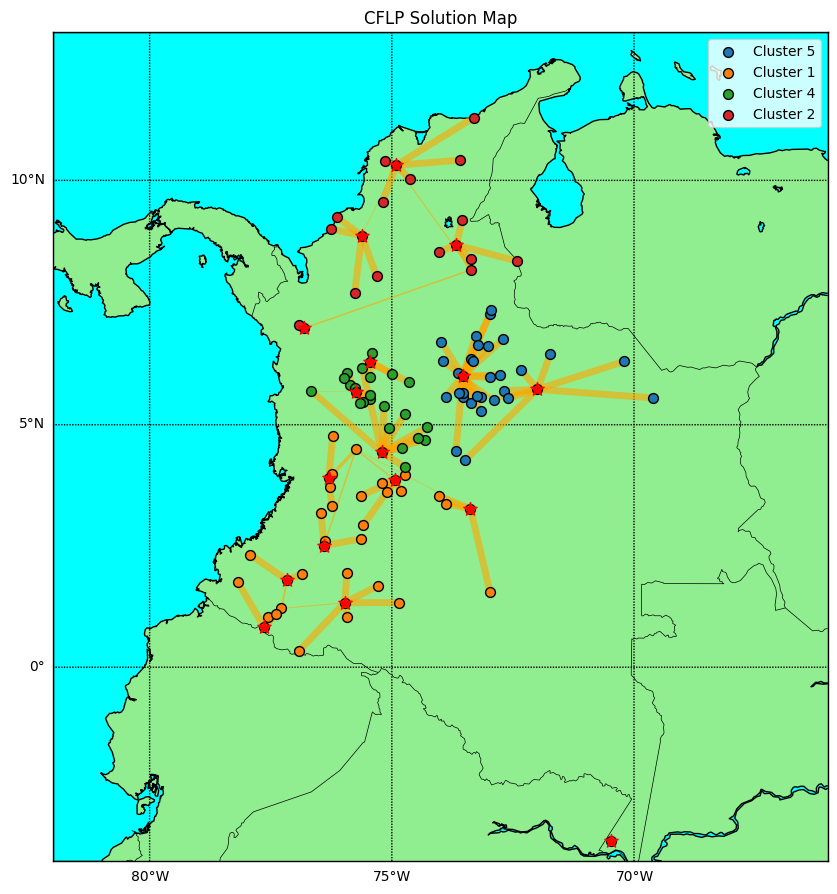

In [94]:
fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(
    projection="merc",
    llcrnrlat=-4,
    urcrnrlat=13,
    llcrnrlon=-82,
    urcrnrlon=-66,
    lat_ts=0,
    resolution="i",
    ax=ax,
)
m.drawcountries()
m.drawmapboundary(fill_color="aqua")
m.fillcontinents(color="lightgreen", lake_color="aqua")
m.drawcoastlines()
m.drawparallels(range(-10, 20, 5), labels=[1, 0, 0, 0])
m.drawmeridians(range(-90, -60, 5), labels=[0, 0, 0, 1])

# Plot municipalities colored by cluster
for cluster in data["cluster"].unique():
    cluster_data = data[data["cluster"] == cluster]
    x, y = m(cluster_data["lon"].values, cluster_data["lat"].values)
    m.scatter(x, y, label=f"Cluster {cluster}", s=50, edgecolor="k", zorder=5)

# Plot demand satisfaction arrows
for cluster in solutions_y.keys():
    for i in solutions_y[cluster].index:
        for j in solutions_y[cluster].columns:
            if solutions_y[cluster].loc[i, j] > 0:
                start_lat = data.loc[i, "lat"]
                start_lon = data.loc[i, "lon"]
                end_lat = data.loc[j, "lat"]
                end_lon = data.loc[j, "lon"]
                x_start, y_start = m(start_lon, start_lat)
                x_end, y_end = m(end_lon, end_lat)
                m.plot(
                    [x_start, x_end],
                    [y_start, y_end],
                    color="orange",
                    linewidth=solutions_y[cluster].loc[i, j] * 5,
                    alpha=0.6,
                    zorder=4,
                )

# Plot open facilities
for cluster in solutions_x.keys():
    open_facilities = solutions_x[cluster][solutions_x[cluster]["open"] == 1].index
    for i in open_facilities:
        x, y = m(data.loc[i, "lon"], data.loc[i, "lat"])
        m.scatter(x, y, color="red", s=100, marker="*", zorder=6)

plt.legend()
plt.title("CFLP Solution Map")
plt.show()
